# Import libraries

In [1]:
%matplotlib inline
import torch as th
import torch.nn.functional as F
import torch.nn as nn 
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance, d2_tweedie_score, make_scorer, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from skorch import NeuralNetRegressor, NeuralNet, callbacks
import utils
import architecture

# Load Models

Get number of units from neural network

In [2]:
all_results_df = pd.read_csv('../results/all_results.csv')
all_results_df 

,params_key,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_module__num_units_2,param_module__num_units_1,params,split0_test_score,mean_test_score,...,test_mean_poisson_deviance,test_weighted_mean_poisson_deviance,test_pde,test_weighted_pde,test_r^2,test_gini,test_min_pred,test_max_pred,test_mean_pred,test_var_pred
0,80_20,776.574228,0.0,0.694507,0.0,80,20,"{'module__num_units_2': 80, 'module__num_units...",0.050370,0.050370,...,0.296193,0.344500,0.072663,0.052246,0.027097,0.284129,0.002416,1.057734,0.055580,0.002170
1,60_20,771.635680,0.0,0.705701,0.0,60,20,"{'module__num_units_2': 60, 'module__num_units...",0.049304,0.049304,...,0.296193,0.344500,0.072663,0.052246,0.027097,0.284129,0.002416,1.057734,0.055580,0.002170
2,20_20,757.642892,0.0,0.699267,0.0,20,20,"{'module__num_units_2': 20, 'module__num_units...",0.048667,0.048667,...,0.296193,0.344500,0.072663,0.052246,0.027097,0.284129,0.002416,1.057734,0.055580,0.002170
3,20_40,768.699820,0.0,0.751259,0.0,20,40,"{'module__num_units_2': 20, 'module__num_units...",0.048022,0.048022,...,0.296193,0.344500,0.072663,0.052246,0.027097,0.284129,0.002416,1.057734,0.055580,0.002170
4,100_20,783.064320,0.0,0.756072,0.0,100,20,"{'module__num_units_2': 100, 'module__num_unit...",0.047218,0.047218,...,0.296193,0.344500,0.072663,0.052246,0.027097,0.284129,0.002416,1.057734,0.055580,0.002170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,80_80,79.229421,0.0,0.060356,0.0,80,80,"{'module__num_units_2': 80, 'module__num_units...",0.014256,0.014256,...,0.309091,0.358371,0.032281,0.014086,0.009112,0.230579,0.006919,1.037850,0.070356,0.002051
161,80_100,82.240442,0.0,0.065340,0.0,80,100,"{'module__num_units_2': 80, 'module__num_units...",0.012320,0.012320,...,0.309091,0.358371,0.032281,0.014086,0.009112,0.230579,0.006919,1.037850,0.070356,0.002051
162,40_60,77.566711,0.0,0.063829,0.0,40,60,"{'module__num_units_2': 40, 'module__num_units...",0.011131,0.011131,...,0.309091,0.358371,0.032281,0.014086,0.009112,0.230579,0.006919,1.037850,0.070356,0.002051
163,100_100,80.547192,0.0,0.063315,0.0,100,100,"{'module__num_units_2': 100, 'module__num_unit...",0.009784,0.009784,...,0.309091,0.358371,0.032281,0.014086,0.009112,0.230579,0.006919,1.037850,0.070356,0.002051


Filter to just best hyperparameters

In [3]:
top_results_df = all_results_df.loc[all_results_df['rank_test_score']==1]
top_results_df

,params_key,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_module__num_units_2,param_module__num_units_1,params,split0_test_score,mean_test_score,...,test_mean_poisson_deviance,test_weighted_mean_poisson_deviance,test_pde,test_weighted_pde,test_r^2,test_gini,test_min_pred,test_max_pred,test_mean_pred,test_var_pred
0,80_20,776.574228,0.0,0.694507,0.0,80,20,"{'module__num_units_2': 80, 'module__num_units...",0.050370,0.050370,...,0.296193,0.344500,0.072663,0.052246,0.027097,0.284129,0.002416,1.057734,0.055580,0.002170
15,40_80,76.416829,0.0,0.059842,0.0,40,80,"{'module__num_units_2': 40, 'module__num_units...",0.032601,0.032601,...,0.304635,0.351720,0.046233,0.032383,0.017320,0.232163,0.002498,0.983369,0.048340,0.001083
30,20_100,77.755391,0.0,0.063352,0.0,20,100,"{'module__num_units_2': 20, 'module__num_units...",0.043135,0.043135,...,0.306521,0.354375,0.040328,0.025079,0.014704,0.204076,0.001813,0.859708,0.050115,0.001150
45,20_80,75.808710,0.0,0.067334,0.0,20,80,"{'module__num_units_2': 20, 'module__num_units...",0.036002,0.036002,...,0.304809,0.351793,0.045687,0.032185,0.015560,0.228910,0.004941,1.008483,0.056085,0.001349
60,20_100,76.422968,0.0,0.066825,0.0,20,100,"{'module__num_units_2': 20, 'module__num_units...",0.036293,0.036293,...,0.304830,0.353576,0.045621,0.027279,0.014042,0.228483,0.003330,0.831236,0.060453,0.002180
75,80_100,78.807838,0.0,0.059841,0.0,80,100,"{'module__num_units_2': 80, 'module__num_units...",0.033130,0.033130,...,0.304876,0.351978,0.045479,0.031675,0.016516,0.232803,0.002178,1.162966,0.053314,0.001757
90,60_20,76.016813,0.0,0.064828,0.0,60,20,"{'module__num_units_2': 60, 'module__num_units...",0.023041,0.023041,...,0.306470,0.353082,0.040487,0.028638,0.014525,0.211289,0.007377,0.801181,0.056839,0.001054
105,20_40,74.955014,0.0,0.062346,0.0,20,40,"{'module__num_units_2': 20, 'module__num_units...",0.023268,0.023268,...,0.306328,0.353263,0.040934,0.028139,0.015155,0.217458,0.005024,0.784100,0.049640,0.001011
120,20_20,71.590384,0.0,0.134663,0.0,20,20,"{'module__num_units_2': 20, 'module__num_units...",0.027256,0.027256,...,0.306593,0.352594,0.040103,0.029981,0.015062,0.215419,0.009962,0.646339,0.049850,0.000812
135,60_20,76.217583,0.0,0.071321,0.0,60,20,"{'module__num_units_2': 60, 'module__num_units...",0.031373,0.031373,...,0.310451,0.358528,0.028025,0.013654,0.012044,0.211504,0.005140,0.485818,0.039293,0.000597


In [4]:
top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']]

,agent,param_module__num_units_1,param_module__num_units_2
0,-1,20,80
15,0,80,40
30,1,100,20
45,2,80,20
60,3,100,20
75,4,100,80
90,5,20,60
105,6,40,20
120,7,20,20
135,8,20,60


Create dictionary to lookup hyperparameters

In [5]:
top_results_dict = top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']].set_index('agent').to_dict('index')
top_results_dict

{-1: {'param_module__num_units_1': 20, 'param_module__num_units_2': 80},
 0: {'param_module__num_units_1': 80, 'param_module__num_units_2': 40},
 1: {'param_module__num_units_1': 100, 'param_module__num_units_2': 20},
 2: {'param_module__num_units_1': 80, 'param_module__num_units_2': 20},
 3: {'param_module__num_units_1': 100, 'param_module__num_units_2': 20},
 4: {'param_module__num_units_1': 100, 'param_module__num_units_2': 80},
 5: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60},
 6: {'param_module__num_units_1': 40, 'param_module__num_units_2': 20},
 7: {'param_module__num_units_1': 20, 'param_module__num_units_2': 20},
 8: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60},
 9: {'param_module__num_units_1': 60, 'param_module__num_units_2': 100}}

Use dictionary to access results, for example to lookup `agent=0`:

In [6]:
top_results_dict[0]

{'param_module__num_units_1': 80, 'param_module__num_units_2': 40}

In [7]:
list(top_results_dict[0].items())[0][1]

80

In [8]:
list(top_results_dict[0].items())[1][1]

40

## Create load model function

In [9]:
def load_model(agent=-1, num_features=39, num_units_1=100, num_units_2=20):

    num_units_1 = list(top_results_dict[agent].items())[0][1]
    num_units_2 = list(top_results_dict[agent].items())[1][1]

    loaded_agent_model = NeuralNetRegressor(architecture.MultipleRegression(num_features, num_units_1, num_units_2).double())
    loaded_agent_model.initialize()  # This is important!
    loaded_agent_model.load_params(f_params=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_model.pkl', 
                                       f_optimizer=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_opt.pkl', 
                                       f_history=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_history.json')
    
    return loaded_agent_model

## Loop through

In [10]:
NUM_AGENTS = 10

In [11]:
agent_model_dictionary = {}
for agents in range(NUM_AGENTS):
    agent_model_dictionary["loaded_agent_{0}_model".format(agents)] = eval('load_model(agent='+str(agents)+')')

## Load Federated Model

In [12]:
fl_model = architecture.MultipleRegression(39)

In [13]:
FL_PATH = '../ag_-1/fl_model.pt'

In [14]:
fl_model.load_state_dict(th.load(FL_PATH))
fl_model.eval()

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=100, bias=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (act): Tanh()
)

Again can lookup each agent's model

In [15]:
agent_model_dictionary['loaded_agent_0_model']

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MultipleRegression(
    (layer_1): Linear(in_features=39, out_features=80, bias=True)
    (layer_2): Linear(in_features=80, out_features=40, bias=True)
    (layer_out): Linear(in_features=40, out_features=1, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (act): Tanh()
  ),
)

## Load global model

In [16]:
loaded_agent_global_model = load_model(agent=-1)

# Load Test Data and Functions

In [17]:
def frequency_conversion(FACTOR, df, freq_dictionary):
      for key in freq_dictionary:
            df[freq_dictionary[key]]=df[key]/df['Exposure']

      df.insert(1,FACTOR+'_binned_midpoint',[round((a.left + a.right)/2,0) for a in df[FACTOR+'_binned']])

In [18]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [19]:
def create_test_data(): 
    (X_train, X_val, X_test, y_train, y_val, y_test, X_column_names, scaler) = utils.upload_dataset()
    
    MY_DATA_PATH = '../data'
    
    X_test_sc = pd.read_csv(MY_DATA_PATH + '/X_test.csv')
    y_te = pd.read_csv(MY_DATA_PATH + '/y_test.csv')
    X_column_names = X_test_sc.columns.tolist()

    test_complete_data=np.column_stack((X_test_sc, y_te))

    X_column_names.append('ClaimNb')

    #Convert dataset of test data, actuals, and prediction back into dataframe

    df_test=pd.DataFrame(data=test_complete_data,    # values
                    columns=X_column_names)  # 1st row as the column names
    
    # Un one-hot encode Region and VehBrand
    df_test = undummify(df_test)
    df_test['VehBrand_number'] = df_test['VehBrand'].str[1:].astype(int)
    df_test['Region_number'] = df_test['Region'].str[1:].astype(int)


    df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']]=scaler.inverse_transform(df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] )
    
    #Bin factors
    factor_list = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']
    
    # If fewer levels than MAX_BINSIZE no effective binning happens via the min() function, not used currently
    MAX_BINSIZE = 20

    # Automatic binning not used, could use qcut as well 
    for i in factor_list:
        df_test[i+'_binned'] = pd.cut(df_test[i], bins=min(len(df_test[i].unique()), MAX_BINSIZE), duplicates='drop')
        #df_test[i+'_binned'] = pd.cut(df_test[i], bins=np.linspace(0, max(df_test[i]), min(21, len(df_test[i].unique()))), duplicates='drop')
    
    # Custom binning used instead to define more sensible bins
    df_test['Area'+'_binned'] = pd.cut(df_test['Area'], bins=np.linspace(0, 7, 8), duplicates='drop')
    df_test['VehPower'+'_binned'] = pd.cut(df_test['VehPower'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['VehAge'+'_binned'] = pd.cut(df_test['VehAge'], bins=np.linspace(0, 20, 21), duplicates='drop')
    df_test['DrivAge'+'_binned'] = pd.cut(df_test['DrivAge'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['BonusMalus'+'_binned'] = pd.qcut(df_test['BonusMalus'], q=15, duplicates='drop') # note usin qcut here
    df_test['Density'+'_binned'] = pd.cut(df_test['Density'], bins=np.linspace(0, 11, 12), duplicates='drop')
    df_test['VehBrand_number'+'_binned'] = pd.cut(df_test['VehBrand_number'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['Region_number'+'_binned'] = pd.cut(df_test['Region_number'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['VehGas'+'_binned'] = pd.cut(df_test['VehGas'], bins=np.linspace(0, 2, 3), duplicates='drop')
    
    return X_test, y_test, df_test

In [20]:
X_test, y_test, df_test = create_test_data()

In [21]:
def create_df_test_pred(df_test, X_test, global_model, NUM_AGENTS):
    
    # Global Model Predictions
    y_pred = global_model.predict(X_test.astype(np.float64))
    df_test['ClaimNb_pred']=pd.Series(y_pred.flatten())

    # FL Model Predictions
    y_fl_pred = fl_model.predict(th.tensor(X_test).float())
    df_test['ClaimNb_fl_pred']=pd.Series(y_fl_pred.flatten().detach().numpy())

    # Local Model Predictions

    agent_prediction_dictionary = {}

    for agents in range(NUM_AGENTS):
        agent_prediction_dictionary["y_agent_{0}_pred".format(agents)] = agent_model_dictionary['loaded_agent_'+str(agents)+'_model'].predict(X_test.astype(np.float64))
        df_test['ClaimNb_agent_'+str(agents)+'_pred']=pd.Series(agent_prediction_dictionary['y_agent_'+str(agents)+'_pred'].flatten())

    return df_test

In [22]:
df_test_pred = create_df_test_pred(df_test, X_test, loaded_agent_global_model, NUM_AGENTS)
df_test_pred

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand,Region,...,ClaimNb_agent_0_pred,ClaimNb_agent_1_pred,ClaimNb_agent_2_pred,ClaimNb_agent_3_pred,ClaimNb_agent_4_pred,ClaimNb_agent_5_pred,ClaimNb_agent_6_pred,ClaimNb_agent_7_pred,ClaimNb_agent_8_pred,ClaimNb_agent_9_pred
0,1.000000,1.0,4.0,11.0,45.0,50.0,1.0,2.197225,B3,R24,...,0.036628,0.038402,0.042833,0.049194,0.042005,0.057861,0.042305,0.037597,0.040369,0.063085
1,0.700000,3.0,7.0,3.0,26.0,68.0,1.0,5.774552,B6,R31,...,0.133856,0.054357,0.037795,0.056818,0.039819,0.050548,0.048749,0.051119,0.042808,0.068128
2,0.460000,4.0,9.0,15.0,21.0,95.0,1.0,6.960348,B3,R24,...,0.061777,0.042812,0.066445,0.087436,0.066788,0.068238,0.059432,0.053487,0.054044,0.093430
3,0.450000,5.0,4.0,0.0,69.0,50.0,1.0,8.325548,B12,R52,...,0.061095,0.068423,0.074217,0.145318,0.089969,0.126715,0.098229,0.058442,0.071996,0.122053
4,0.490000,6.0,9.0,1.0,57.0,50.0,1.0,10.060320,B2,R21,...,0.055497,0.056451,0.047660,0.075929,0.056784,0.059505,0.071899,0.056993,0.039042,0.078766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,0.070000,3.0,9.0,0.0,53.0,50.0,1.0,5.953243,B12,R82,...,0.078834,0.073732,0.064192,0.147487,0.149450,0.060226,0.060103,0.048684,0.050533,0.087560
135599,0.110000,3.0,9.0,16.0,37.0,50.0,1.0,6.003887,B14,R24,...,0.008382,0.048850,0.015244,0.007259,0.017816,0.021787,0.011349,0.015483,0.007709,0.021594
135600,0.008219,4.0,7.0,0.0,56.0,50.0,1.0,6.628041,B12,R26,...,0.055505,0.083162,0.058377,0.115858,0.132142,0.075550,0.041361,0.042268,0.105309,0.055843
135601,0.280000,5.0,5.0,17.0,50.0,90.0,1.0,9.138522,B5,R82,...,0.066484,0.072809,0.090078,0.046328,0.063462,0.055905,0.053313,0.049418,0.032451,0.102016


In [23]:
def create_df_sum(df_test_pred, factor, NUM_AGENTS):

    sum_list = ['Exposure',  'ClaimNb', 'ClaimNb_pred', 'ClaimNb_fl_pred']
    sum_dictionary = {'ClaimNb':'Actual freq', 'ClaimNb_pred':'Freq pred global model', 'ClaimNb_fl_pred':'Freq pred FL model'}

    for agents in range(NUM_AGENTS):
        sum_list.append('ClaimNb_agent_'+str(agents)+'_pred')
        sum_dictionary['ClaimNb_agent_'+str(agents)+'_pred']='Freq pred agent '+str(agents)+' model'

    df_sum=df_test_pred.groupby([factor+'_binned'])[sum_list].sum().reset_index()

    frequency_conversion(factor, df_sum, sum_dictionary)

    # Remove rows with 0 exposure
    df_sum = df_sum.loc[df_sum['Exposure']!=0]
    df_sum = df_sum.reset_index(drop=True)

    return df_sum

In [24]:
def one_way_graph_comparison(factor, NUM_AGENTS):

        df_sum = create_df_sum(df_test_pred, factor, NUM_AGENTS)
        
        fig, ax = plt.subplots(figsize=(12, 8))

        plt.plot(df_sum['Actual freq'],  
                label='Actual freq',
                marker='s',
                markersize=10,
                )
        
        for agents in range(NUM_AGENTS):
                plt.plot(df_sum['Freq pred agent '+str(agents)+' model'],  
                label='Freq pred agent '+str(agents)+' model',
                marker='o',
                markersize=5,
                linestyle=(0, (1, 10)),
                #linestyle='dotted',
                )


        plt.plot(df_sum['Freq pred FL model'],  
                label='Freq pred FL model',
                marker='o',
                markersize=10,
                #linestyle='dotted',
                )
        
        plt.plot(df_sum['Freq pred global model'],  
                label='Freq pred global model',
                marker='s',
                markersize=10,
                #linestyle='dotted',
                )

        plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

        plt.xlabel(factor+'_binned')
        plt.xticks(rotation = 75)
        plt.ylabel('Frequency')
        plt.grid()


        # Get second axis
        ax2 = ax.twinx()

        plt.bar(df_sum[factor+'_binned'].astype(str), 
                df_sum['Exposure'], 
                label='Exposure', 
                color='y',
                alpha=0.35
                )

        plt.ylabel('Exposure', color='y')
        plt.xticks(rotation = 90)

        vals = ax2.get_yticks()
        ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

        plt.legend(bbox_to_anchor=(1.08, 0), loc='upper left', borderaxespad=0)

        plt.show()

# Graphs

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


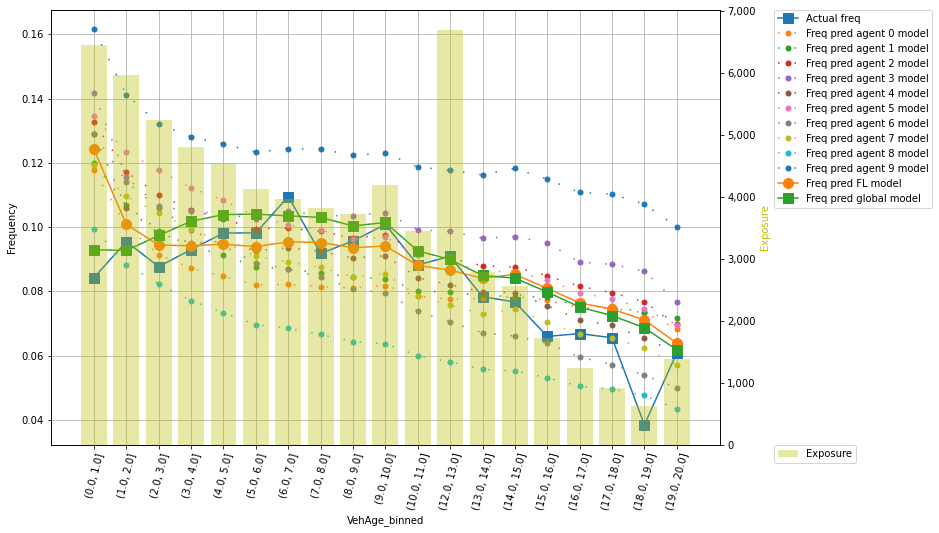

In [25]:
one_way_graph_comparison('VehAge', NUM_AGENTS)

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


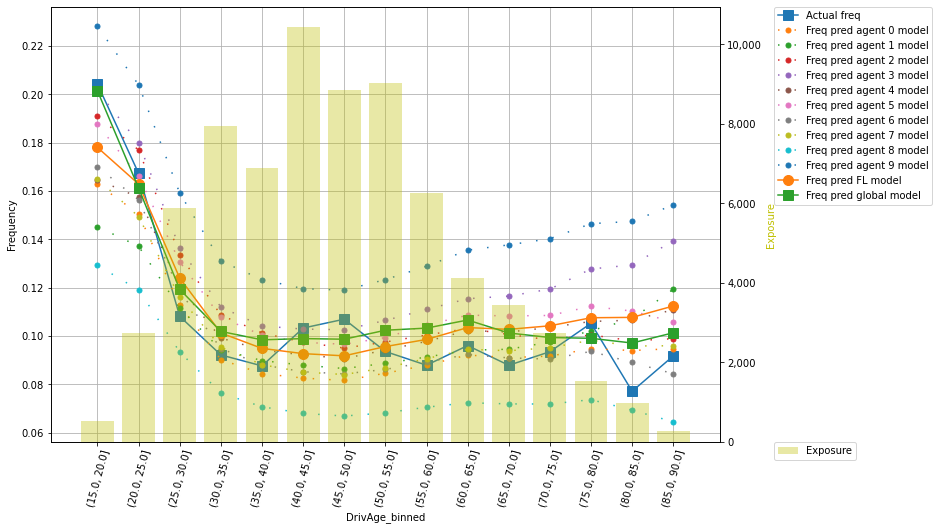

In [26]:
one_way_graph_comparison('DrivAge', NUM_AGENTS)

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


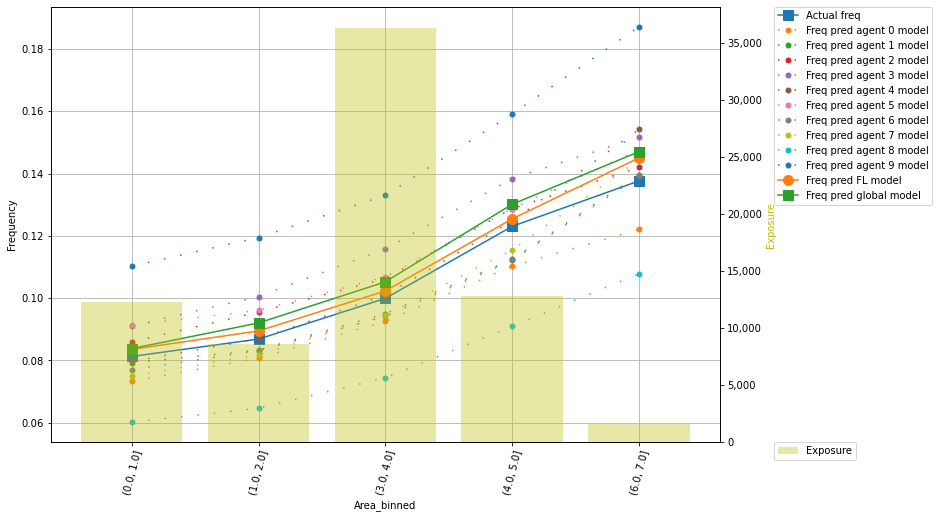

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


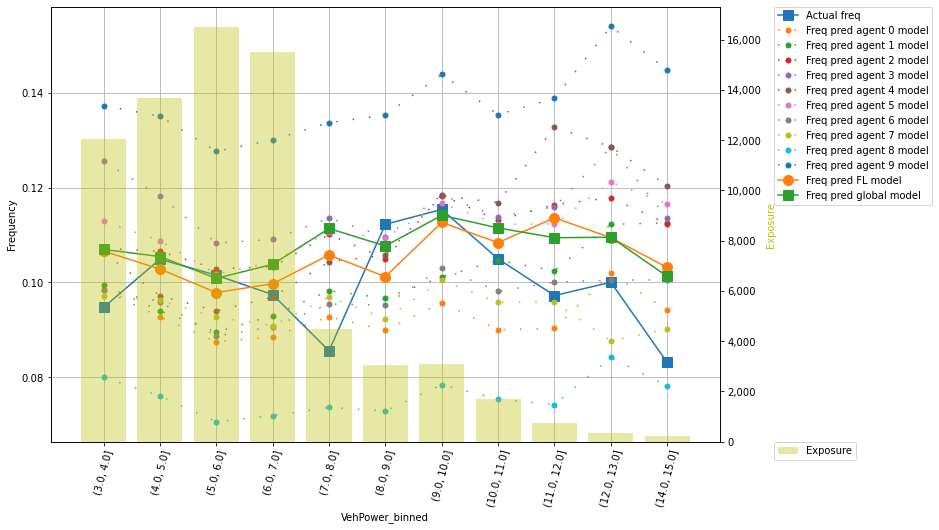

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


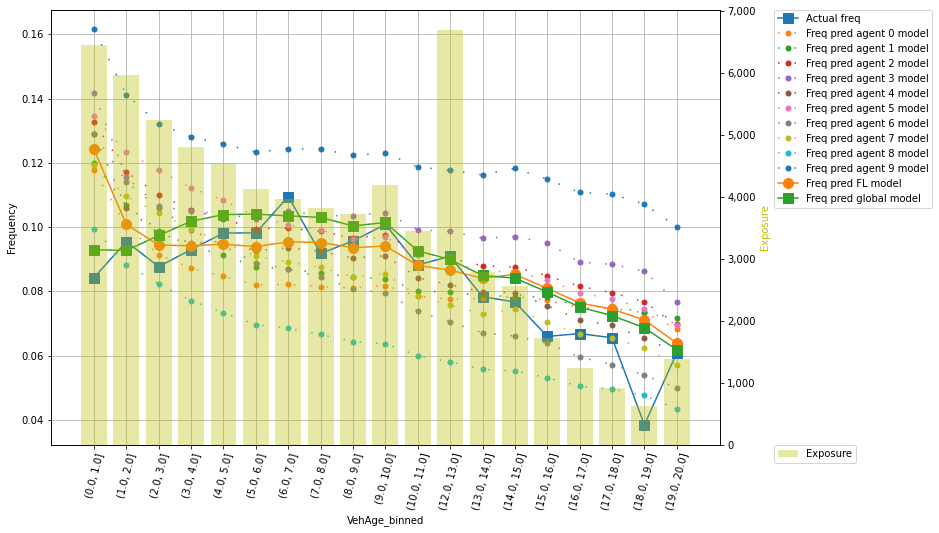

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


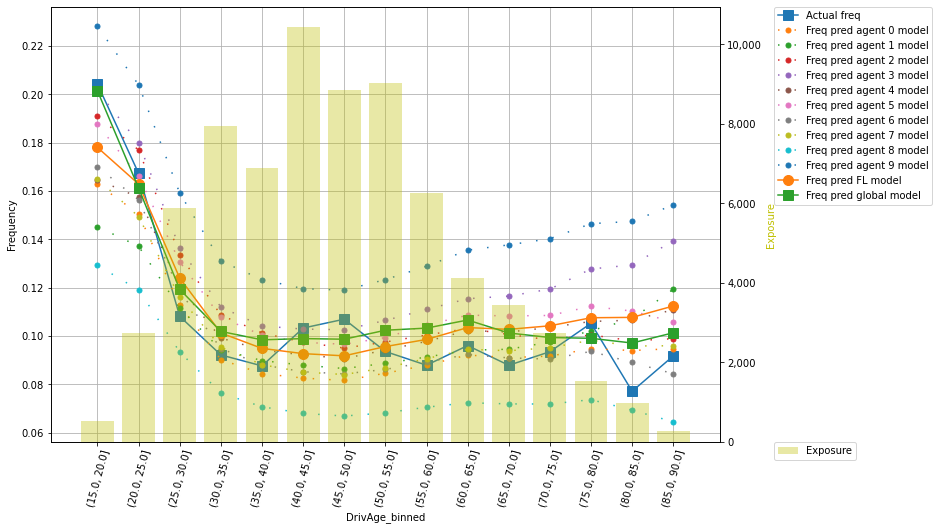

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


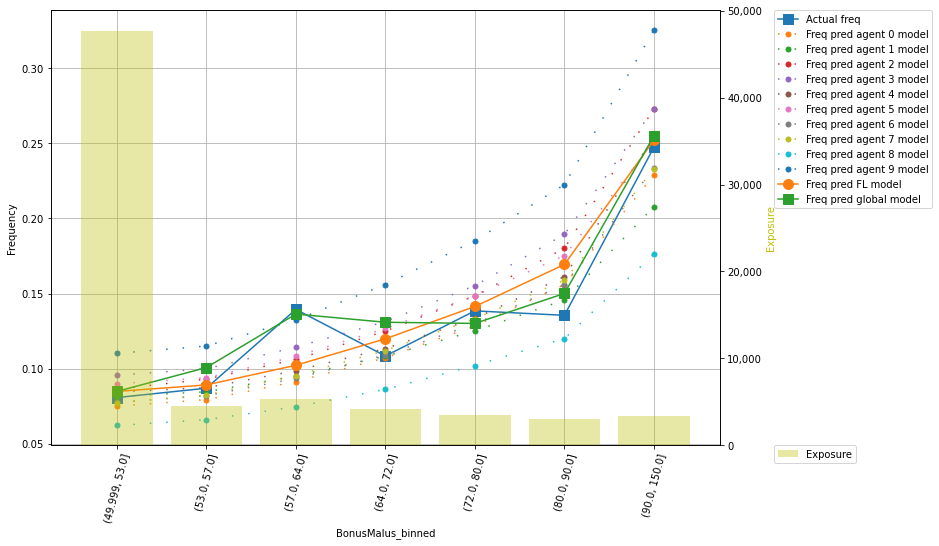

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


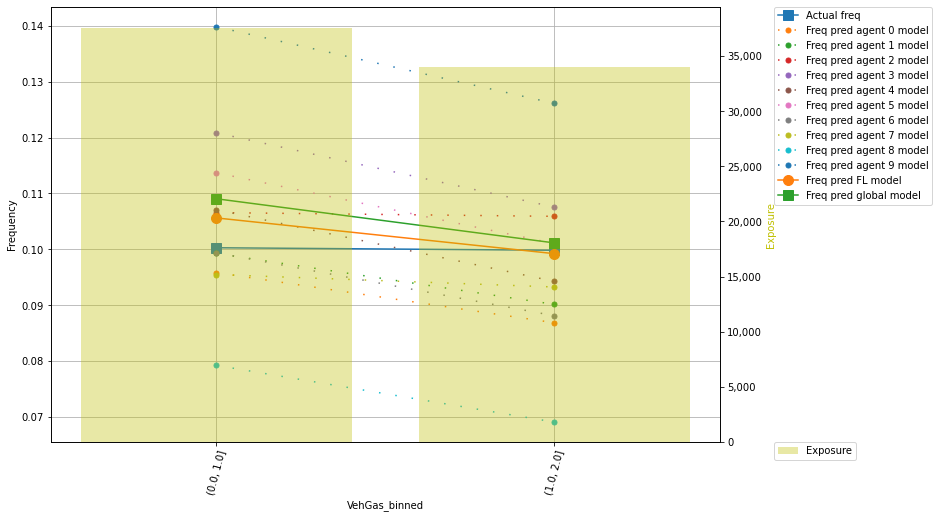

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


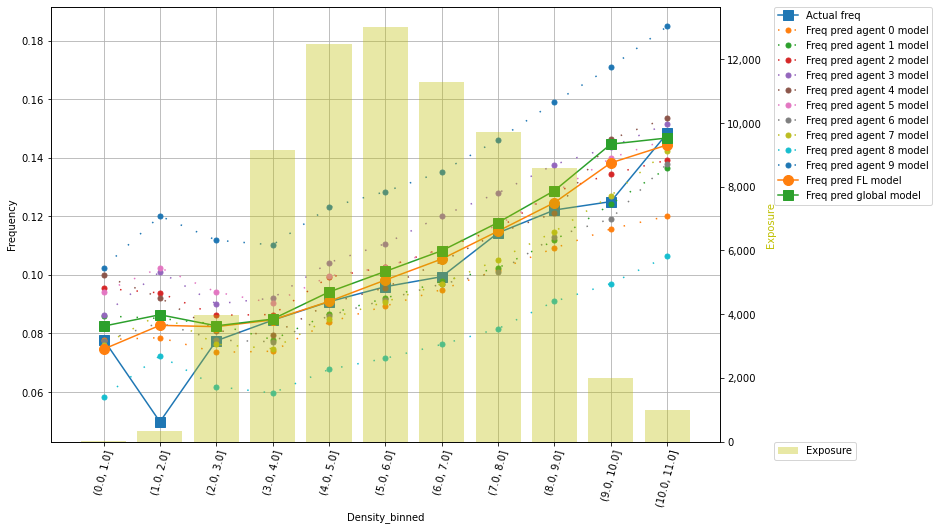

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


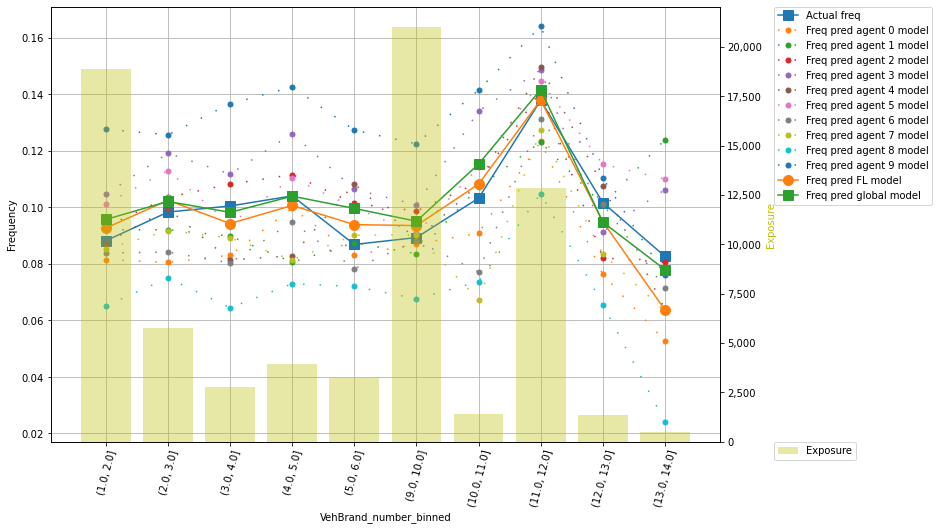

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


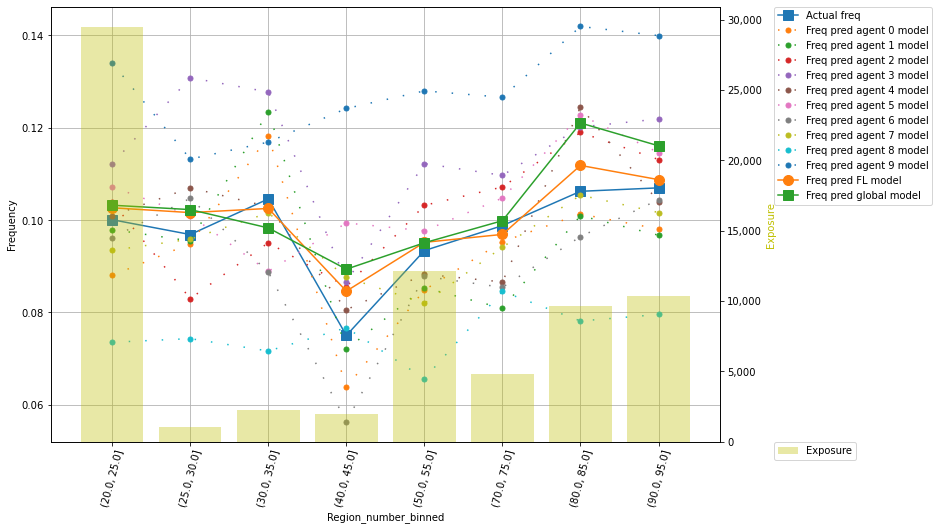

In [27]:
for i in ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']:
    one_way_graph_comparison(i, NUM_AGENTS)

## Gini

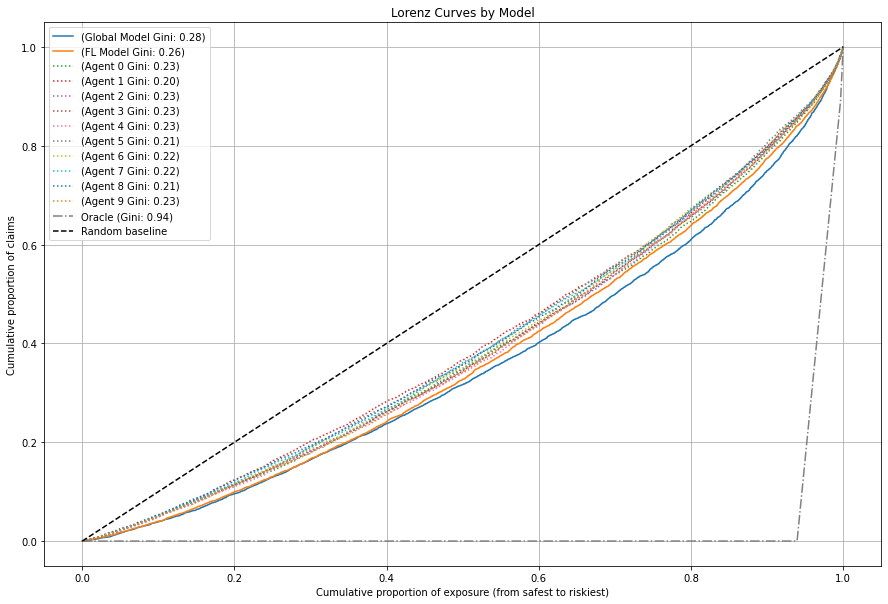

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(Global Model Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_fl_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(FL Model Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

for agents in range(NUM_AGENTS):
    cum_exposure, cum_claims = utils.lorenz_curve(
        df_test_pred['ClaimNb'], df_test_pred['ClaimNb_agent_'+str(agents)+'_pred'], df_test_pred["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = '(Agent {} Gini: {:.2f})'.format(agents, gini)
    plt.plot(cum_exposure, cum_claims, linestyle="dotted", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves by Model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)

plt.grid()
ax.legend(loc="upper left")

#plt.savefig(f'../ag_{ag}/' + 'lift_chart')

# Metric

In [29]:
y_fl_tensor_pred = fl_model.predict(th.tensor(X_test).float())

In [30]:
y_fl_pred=pd.Series(y_fl_tensor_pred.flatten().detach().numpy())

In [31]:
y_fl_pred= df_test['ClaimNb_fl_pred']

In [32]:
fl_weighted_pde = d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)
fl_weighted_pde 

0.04378973194770386

In [33]:
weighted_pde_df = top_results_df[['agent', 'test_weighted_pde']]
weighted_pde_df

,agent,test_weighted_pde
0,-1,0.052246
15,0,0.032383
30,1,0.025079
45,2,0.032185
60,3,0.027279
75,4,0.031675
90,5,0.028638
105,6,0.028139
120,7,0.029981
135,8,0.013654


In [34]:
weighted_pde_df.loc[151] = [-2, d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)]
weighted_pde_df

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\1077199988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df.loc[151] = [-2, d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)]


,agent,test_weighted_pde
0,-1.0,0.052246
15,0.0,0.032383
30,1.0,0.025079
45,2.0,0.032185
60,3.0,0.027279
75,4.0,0.031675
90,5.0,0.028638
105,6.0,0.028139
120,7.0,0.029981
135,8.0,0.013654


In [35]:
weighted_pde_df['fl_relative_increase'] = fl_weighted_pde/weighted_pde_df['test_weighted_pde']
weighted_pde_df

C:\Users\dylan\AppData\Local\Temp\ipykernel_273396\2101612733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df['fl_relative_increase'] = fl_weighted_pde/weighted_pde_df['test_weighted_pde']


,agent,test_weighted_pde,fl_relative_increase
0,-1.0,0.052246,0.838144
15,0.0,0.032383,1.352229
30,1.0,0.025079,1.746071
45,2.0,0.032185,1.360574
60,3.0,0.027279,1.605276
75,4.0,0.031675,1.382469
90,5.0,0.028638,1.529096
105,6.0,0.028139,1.556169
120,7.0,0.029981,1.460590
135,8.0,0.013654,3.207212


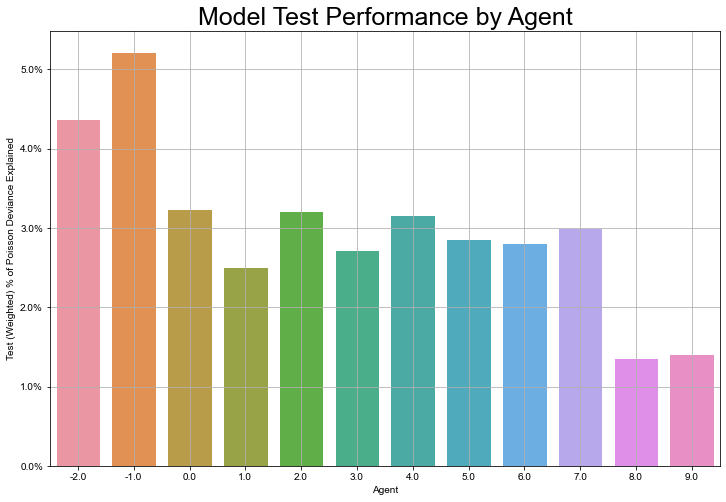

In [36]:
fig, ax = plt.subplots(figsize=(12,8))

sns.set_style('white')

ax=sns.barplot(x='agent', y='test_weighted_pde',
               data=weighted_pde_df[['agent', 'test_weighted_pde']])
plt.title('Model Test Performance by Agent', fontsize=25)

plt.xticks(fontsize=10)
plt.ylabel('Test (Weighted) % of Poisson Deviance Explained', fontsize=10)
plt.xlabel('Agent', fontsize=10)
plt.yticks(fontsize=10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(True)
plt.show()

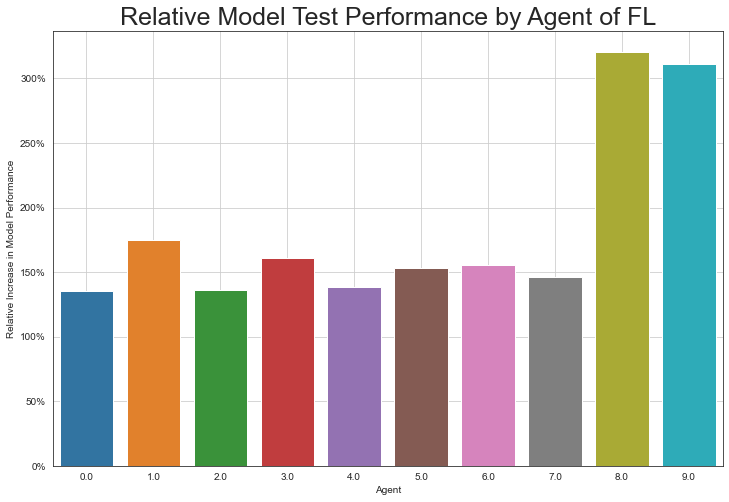

In [39]:
fig, ax = plt.subplots(figsize=(12,8))

sns.set_style('white')

ax=sns.barplot(x='agent', y='fl_relative_increase',
               data=weighted_pde_df[~weighted_pde_df.agent.isin([-1, -2])])
plt.title('Relative Model Test Performance by Agent of FL', fontsize=25)

plt.xticks(fontsize=10)
plt.ylabel('Relative Increase in Model Performance', fontsize=10)
plt.xlabel('Agent', fontsize=10)
plt.yticks(fontsize=10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(True)
plt.show()

# End